### Imports

In [1]:
# imports
import numpy as np
from astropy import units as u
from astropy import coordinates as c
from astropy.cosmology import units as cu
import matplotlib.pyplot as plt
from matplotlib import rcParams as P
from scipy.spatial.transform import Rotation as R
import math

### Helper functions

#### angle generator

In [2]:
def generate_angles():
    # generates the 3 needed euler angles at random
    # angles
    alpha = 2 * np.pi * np.random.random()  #generate random rotation angles
    beta = np.pi * np.random.random()
    gamma = 2 * np.pi * np.random.random()
    
    # alpha, beta, gamma = 0.1, 0, 0
    
    return (alpha, beta, gamma)

#### galaxy rotator

In [3]:
# This function performs an Euler rotation on the data, returns the new glon and glat
# prof. watkins' code (plus some additions of my own)
# uses scipy to preform a random euler rotation  
def rotate(array, angles):
    
    # 'angles' tuple must have 3 elements that coorespons to the euler angles of rotation
    alpha, beta, gamma = angles
    
    # data part
    glon = array[10] * np.pi / 180
    glat = array[11] * np.pi / 180

    #make glon and glat into array of positions on the unit sphere
    pos = np.array([np.cos(glon) * np.cos(glat),  # alpha
                    np.sin(glon) * np.cos(glat),  # beta
                    np.sin(glat)])                # gamma

    pos = np.transpose(pos)

    r = R.from_euler('xzx', [alpha, beta, gamma]) #create the rotation
    posprime = r.apply(pos)  #apply the rotation to the vectors

    glonprime = np.arctan2(posprime[1], posprime[0]) * 180 / np.pi  #convert back to degrees
    # glonprime[glonprime < 0] = 360 + glonprime[glonprime < 0]
    if glonprime < 0:
        glonprime += 360

    glatprime = np.arcsin(posprime[2]) * 180/np.pi
    
    # glonprime, glatprime = c.Angle(glonprime, u.degree), c.Angle(glatprime, u.degree)
    glonprime = c.Angle(glonprime, u.degree)
    glatprime = c.Angle(glatprime, u.degree)
    
    # print(f'{alpha=}, {beta=}, {gamma=}')  # angles of rotation (radians)
    glonprime, glatprime = glonprime.wrap_at('180d', inplace=False).value, glatprime.value
    
    return glonprime, glatprime

#### bulkflow rotator

In [4]:
def rotate_bulkflow(bulkflow, angles: tuple):
    # rotates one bulkflow for ONE catalogue at a time, to be used in a loop in sync with the previous rotate function
    
    # 'angles' tuple must have 3 elements that coorespons to the euler angles of rotation
    alpha, beta, gamma = angles
    
    # rotation part
    r = R.from_euler('xzx', [alpha, beta, gamma])
    bulkflowprime = r.apply(bulkflow)
        
    return bulkflowprime  # returns an array of the new components of the new bulkflow

#### distance modulus 

In [5]:
# evaluating distance mod
def distance_mod(line, error):
    distance = line[7]
    return 5 * math.log10(distance) + 25 + error

#### Loading, processing, rotating the data

In [6]:
def main():

    bulkflows = np.load('C:/Users/yaras/Documents/Research/Feldman/outerrim/CF3-OuterRim-CF3grouplike-cz-rand/true_bulkflows100.npy')

    # load the data
    for i in range(1): # use range(300) to run on all catalogues (BAD IDEA)
        data = np.load(f'C:/Users/yaras/Documents/Research/Feldman/outerrim/CF3-OuterRim-CF3grouplike-cz-rand/CF3-OuterRim-CF3grouplike-cz-rand-box-{i}.npy')
        for v in range(3):

            # all arrays will have size 11132x7
            new_cat = np.empty((0,7))
            
            # accounting for zone of avoidance
            indices = np.where(abs(data[:,11]) > 5)
            data = data[indices]
            np.random.shuffle(data)
            data = data[:11132]  # 11132 is the size of the smallest catalogue
            

            # generating multiple versions of each catalogue
            for line in data:
                '''
                generating angles of rotation
                'angles' will be a tuple with 3 elements (alpha, beta, gamma)
                look cell No. 4 (generate angles) for function definition
                '''
                angles = generate_angles()
                
                
                '''
                rotating the bulkflows
                'bulkflow' will be a 1x3 array with the xyz components
                of the bulkflow for the respective catalogue
                look cell No. 6 (bulkflow rotator) for function definition
                '''
                bulkflow = bulkflows[:,i]
                bulkflow_prime = rotate_bulkflow(bulkflow, angles)
                
                '''
                euler rotation of the data using the generated angles
                '''
                glonprime, glatprime = rotate(line, angles)
                
                '''
                generating an error between 0 and 40% on a galcian distribution
                '''
                error = np.random.normal() * 0.4
                # error = 0  # uncomment this to set error to 0
                
                '''
                distance modulus
                '''
                d_mod = distance_mod(line, error)
                
                '''
                redshift
                '''
                redshfit = line[6]
                
                '''
                writing the new line
                '''
                new_array = np.array([redshfit,   # redshift
                                    d_mod,      # distance modulus
                                    glonprime,  # galactic longitude prime
                                    glatprime,  # galactic latitude prime
                                    bulkflow_prime[0],   # bulkflow x
                                    bulkflow_prime[1],   # bulkflow y
                                    bulkflow_prime[2]])  # bulkflow z
                # print(new_array) 
                
                new_cat = np.append(new_cat, [new_array], axis=0)
               
            # print(new_cat)
            np.save(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-{i}-version-{v}.npy', new_cat)
                
        
# (un)comment to generate new versions
main()
    

In [12]:
data = np.load(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-0-version-0.npy')
print(len(data[:,0]))
print(len(data[:,1]))
print(len(data[:,2]))
print(len(data[:,3]))
print(len(data[:,4]))
print(len(data[:,5]))
print(len(data[:,6]))
print(data[:,4])
print(data[:,5])
print(data[:,6])


10603
10603
10603
10603
10603
10603
10603
[-102.35274884 -122.26069605  141.45573796 ...  251.51985658  251.12852105
  146.62775516]
[  35.06458434  188.13777025 -185.08316252 ...  -28.22502339  -16.44771054
 -239.73811533]
[ 262.18444167 -173.50156578 -161.80478631 ... -128.01328651  130.80607958
   38.36963902]


#### visualizing the data

C:\Users\yaras\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
C:\Users\yaras\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\stride_tricks.py:341: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(array, copy=False, subok=subok)
C:\Users\yaras\AppData\Local\Packages\PythonSof

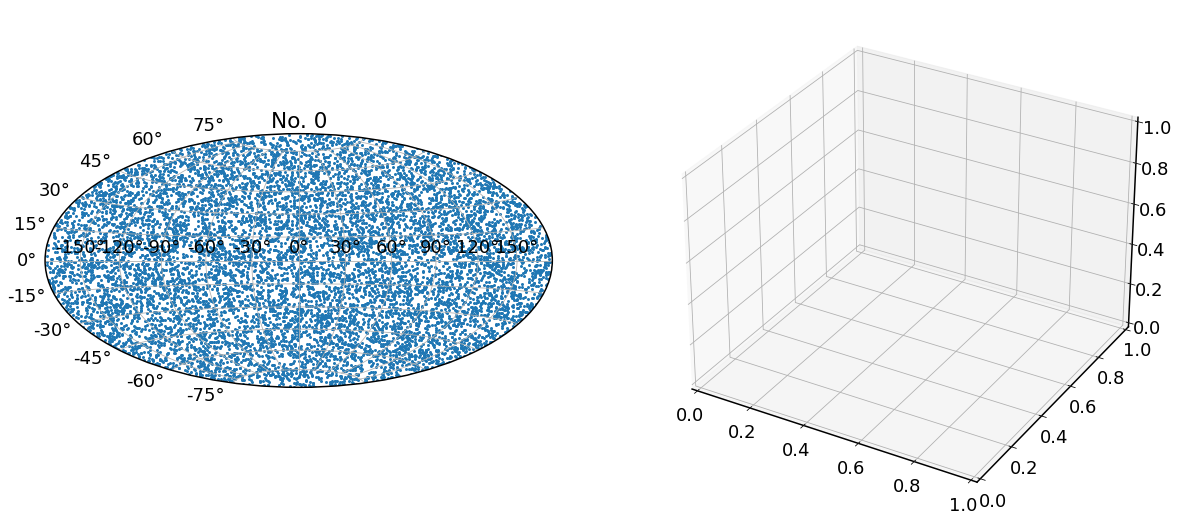

In [8]:
# for generating figures
# for i in range(1):
#     for v in range(1):
        # C:/Users/yaras/Documents/Research/Feldman/
data = np.load(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-0-version-0.npy')

# processing the ORIGINAL data, we dont need this for making the new catalogues
# ------------------------------------
# glat and glon are in degrees, make unit objects to ease operations
glon, glat = data[: ,2], data[: ,3]
glon = c.Angle(glon, u.degree)
glat = c.Angle(glat, u.degree)
            
# changing range of glon to (-180, 180) instead of (0, 360)
glon = glon.wrap_at('180d', inplace=False)

# Accounting for zone of avoidance (taking out data points with -5 < glat < 5)
# indices = np.where(abs(glat.value) > 5)
# glon = glon[indices]
# glat = glat[indices]
# # -------------------------------------

# making figure
fig = plt.figure(figsize=(20, 20))
P.update({'font.size': 18,
                'axes.linewidth': 1.5,
                'axes.labelweight': 'bold',
                })

# subplot 1
ax1 = fig.add_subplot(121, projection='hammer')
ax1.scatter(glon.radian, glat.radian, marker='.', linewidths=0.1)
ax1.grid(True)
ax1.title.set_text(f'No. 0')

x,y,z = data[:,4], data[:,5], data[:,6]

ax = fig.add_subplot(122, projection='3d')
ax.plot((0, x) ,(0, y),(0, z))
ax.scatter(x,y,z)
ax.view_init(-155, 45)

fig.show()

#### misc

In [ ]:
# data = np.load(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-0-version-2.npy')
# for line in data:
#     print(line)

In [ ]:
# # this cell helped me find the smallest and largest catalogues
# print(max([len(np.load(f'C:/Users/yaras/Documents/Research/Feldman/outerrim/CF3-OuterRim-CF3grouplike-cz-rand/CF3-OuterRim-CF3grouplike-cz-rand-box-{i}.npy')) for i in range(300)]))
# print(min([len(np.load(f'C:/Users/yaras/Documents/Research/Feldman/outerrim/CF3-OuterRim-CF3grouplike-cz-rand/CF3-OuterRim-CF3grouplike-cz-rand-box-{i}.npy')) for i in range(300)]))
# # max: 11809
# # min: 11132